# 导包

In [1]:
import torch
import torchvision
import torch.nn
import torch.nn.init
import torch.utils.data as data
print(torch.__version__)
print(torchvision.__version__)
print(torch.cuda.is_available())
import matplotlib.pyplot as plt
from IPython import display
import numpy as np
import random

1.0.0
0.2.2
True


In [2]:
from data import *

# 数据生成
为了使用SGD优化算法，要把大的数据集变成一个一个小批量。

* `torch.utils.data.TensorDataset`
* `torch.utils.data.DataLoader`

## 输入向量化

把图像等高维度特征展开成一维特征，每个示例一行。

`(batch_size, c1, c2, c3, ...)` → `(barch_size, features_num=c1xc2xc3x...)`


In [3]:
class FlattenLayer(torch.nn.Module):
    """
    把图像等高维度特征展开成一维特征，每个示例一行。
    """
    def __init__(self):
        super(FlattenLayer, self).__init__()
    def forward(self, x): # x shape: (batch, *, *, ...)
        return x.view(x.shape[0], -1)

## 小批量迭代器

In [4]:
def data_iter(batch_size, features, labels):
    """
    遍历数据集并不断读取小批量数据样本。

    :param batch_size:批量大小；
    :param features:特征Tensor；
    :param labels:标签Tensor；
    :return:小样本（特征,标签）迭代器；
    """
    num_examples = len(features)
    indices = list(range(0,num_examples))
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        j = torch.LongTensor(indices[i:min(i+batch_size,num_examples)])
        yield features.index_select(0,j), labels.index_select(0,j)

# 模型

- `torch.nn`

## 网络参数初始化
- 模型参数随机初始化：`torch.nn.init`
- 模型参数附加梯度

## 线性回归

linreg相当于只有一个神经元的神经网络。
$$\hat{y} = {X} {w} + b$$

![线性回归是单层神经网络](http://zh.gluon.ai/_images/linreg.svg)

In [5]:
def linreg(X, W, b):
    """
    线性回归。

    :param X:输入矩阵（batch_size, features_num）；
    :param W:权重矩阵（features_num, lables_num)，labels_num一般为1；
    :param b:偏置向量（lables_num)；
    :return:输出矩阵(batch_size, labels_num)；
    """
    return X.mm(X)+b

## softmax

softmax相当于多个神经元构成的单层神经网络：
$$
\begin{split}\begin{aligned}
{o}^{(i)} &= {x}^{(i)} {W} + {b},\\
{\hat{y}}^{(i)} &= {softmax}(\boldsymbol{o}^{(i)}).
\end{aligned}\end{split}
$$

![softmax是一个单层神经网络](http://zh.gluon.ai/_images/softmaxreg.svg)

In [6]:
def softmax(X):
    """
    转换后，任意一行元素代表了一个样本在各个输出类别上的预测概率，概率之和为1。

    :param X:特征强度矩阵（batch_size, features_num）；
    :return:特赠概率矩阵（batch_size, features_num）；
    """
    X_exp = X.exp()
    partition = X_exp.sum(dim=1, keepdim=True)
    return X_exp / partition

## 多层感知机

![MLP](http://zh.gluon.ai/_images/mlp.svg)

没有激活函数的多层感知机等效于单层神经网络,多层感知机在每个隐藏层上加入激活函数。

# 激活函数

In [7]:
a = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)

In [8]:
def xyplot(x_vals, y_vals, name):
    display.set_matplotlib_formats("svg")
    plt.rcParams["figure.figsize"]=(5, 2.5)
    plt.plot(x_vals.detach().numpy(), y_vals.detach().numpy())
    plt.xlabel('x')
    plt.ylabel(name + '(x)')

## reLu
$$\text{ReLU}(x) = \max(x, 0).$$

In [9]:
def relu(O):
    """
    对隐藏层的输出进行激活。
    :param O: 上一层的线性变换结果(batch_size, hiddens_num)
    :return: 隐藏层的输出(batch_size, hiddens_num)
    """
    return torch.max(input=O, other=torch.tensor(0.0))

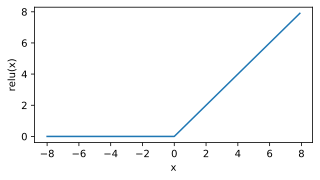

In [10]:
xyplot(a,relu(a),"relu")

## sigmoid
softmax在二分类下的特殊情况。
$$\text{sigmoid}(x) = \frac{1}{1 + \exp(-x)}\\
\text{sigmoid}'(x) = \text{sigmoid}(x)\left(1-\text{sigmoid}(x)\right)$$

In [11]:
def sigmoid(O):
    """
    对隐藏层的输出进行sigmoid激活。
    :param O: 上一层的线性变换结果(batch_size, hiddens_num)
    :return: 隐藏层的输出(batch_size, hiddens_num)
    """
    return 1 / (1+torch.exp(-O))

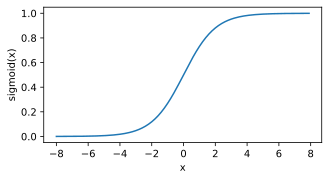

In [12]:
xyplot(a,sigmoid(a),"sigmoid")

## tanh
$$\text{tanh}(x) = \frac{1 - \exp(-2x)}{1 + \exp(-2x)}\\
\text{tanh}'(x) = 1 - \text{tanh}^2(x)$$

In [13]:
def tanh(O):
    """
        对隐藏层的输出进行tanh激活。
        :param O: 上一层的线性变换结果(batch_size, hiddens_num)
        :return: 隐藏层的输出(batch_size, hiddens_num)
        """
    return (1-torch.exp(-2*O))/(1+torch.exp(-2*O))

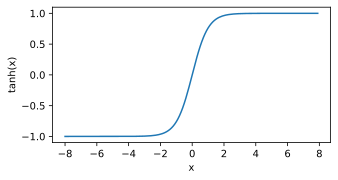

In [14]:
xyplot(a,tanh(a),"tanh")

# 损失函数
- `torch.nn.MSELoss`
- `torch.nn.CrossEntropyLoss`

## 平方损失函数
用于回归。

$$\ell^{(i)}(w_1, w_2, b) = \frac{1}{2} \left(\hat{y}^{(i)} - y^{(i)}\right)^2,$$

In [15]:
def squared_loss(y_hat, y):
    """
    计算平方损失函数，一般y_hat为（batch_size,1）的二维矩阵，y为(batch_size,)的一维向量。

    :param y_hat:模型预测值
    :param y:标签真实值
    :return:损失矩阵（batch_size,1），每个示例的平方损失。
    """
    return (y_hat-y.reshape(y_hat.shape)) ** 2 / 2

## 交叉熵损失函数
用于分类。

$$H( y^{(i)}, {\hat y}^{(i)}) = -\log \hat y_{y^{(i)}}^{(i)}$$

In [16]:
# torch的指标是LongTensor类型。
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y = torch.LongTensor([0, 2])
y_hat.gather(1, y.view(-1, 1))

tensor([[0.1000],
        [0.5000]])

In [17]:
def cross_entropy(y_hat, y):
    """
    求预测概率矩阵和真实标签onehot的交叉熵。
    
    :param y_hat:各个类别上的概率矩阵（batch_size, labels_num)
    :param y:真实标签向量(batch_size，)
    :return:各个示例的交叉熵（batch_size,1)
    """
    return - torch.log(y_hat.gather(1, y.view(-1, 1)))

# 指标函数

## 准确度accuracy

In [18]:
def accuracy(y_hat, y):
    """
    求预测概的准确率(TP+TN)/(TP+TN+FP+FN)。

    :param y_hat:各个类别上的概率矩阵（batch_size, labels_num)
    :param y:真实标签向量(batch_size，)
    :return: 准确度指标
    """
    return (y_hat.argmax(dim=1) == y).float().mean().item()

In [19]:
def evaluate_accuracy(dataiter, net):
    """
    求模型在数据集上的准确率指标。
    
    :param dataiter: 数据集迭代器（features, labels)
    :param net: 模型。
    :return: 准确度指标
    """
    acc_sum, n = 0.0, 0
    for X, y in dataiter:
        acc_sum += (net(X).argmax(dim=1) == y).float().sum().item()
        n += y.shape[0]
    return acc_sum / n

# 优化函数
- `torch.optim.SGD`

In [20]:
from functools import partial

In [21]:
def sgd(params, lr, batch_size):
    """
    小批量随机梯度下降优化器。

    :param params:待优化模型的参数。
    :param lr:学习率。
    :param batch_size:批量大小。
    :return:
    """    
    for param in params:
        param.data -= lr * param.grad / batch_size
    

# 训练模型

1. 梯度清零
2. 求损失函数
3. 损失函数backward
4. 优化器step


## 分类训练

In [22]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size,
              params=None, lr=None, optimizer=None):
    """
    训练深度学习分类模型（网络）。
    train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, batch_size, net.parameters(), lr)

    :param net:深度学习模型。
    :param train_iter:训练数据集迭代器（features, labels）。
    :param test_iter:测试数据集迭代器（features, labels）。
    :param loss:损失函数。
    :param num_epochs:学习周期。
    :param batch_size:批量大小。
    :param params:模型参数集。
    :param lr:学习率。
    :param optimizer:优化器,有zero_grad和step。
    :return:None
    """
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        for X, y in train_iter:
            y_hat = net(X)
            l = loss(y_hat, y).sum()

            if optimizer is not None:
                optimizer.zero_grad()
            elif params is not None and params[0].grad.data is not None:
                for param in params:
                    param.grad.data.zero_()

            l.backward()
            if optimizer is None:
                sgd(params, lr, batch_size)
            else:
                optimizer.step()

            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
            n += y.shape[0]
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc))

# 示例

## FASHION-MNIST

In [23]:
batch_size = 256
num_workers=4

In [24]:
train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [25]:
num_epochs, lr = 5, 0.03

In [26]:
num_inputs, num_outputs, num_hiddens = 784, 10, 256

### sigmoid

#### 模型参数初始化

In [27]:
W = torch.tensor(np.random.normal(0,0.01,size=(num_inputs, num_outputs)), dtype=torch.float)
b = torch.zeros(num_outputs, dtype=torch.float)
params1 = [W,b]
for param in params1:
    param.requires_grad_(requires_grad=True)

#### 定义网络

In [28]:
def net_sigmoid(X):
    num_inputs = W.shape[0]
    return softmax(torch.mm(X.view(-1, num_inputs), W)+b)

In [29]:
loss = cross_entropy

#### 训练

In [30]:
# for epoch in range(1, num_epochs+1):
#     train_l_sum, train_acc_sum,n = 0.0,0.0,0
#     for X, y in train_iter:
#         y_hat = net_sigmoid(X)
#         l = loss(y_hat,y).sum()
#         l.backward()
#         sgd([W,b], lr, batch_size)
#         for param in params1:
#             param.grad.data.zero_()
        
#         train_l_sum += l.item()
#         train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
#         n += y.shape[0]
#     test_acc = evaluate_accuracy(test_iter,net_sigmoid)
#     print("epoch {:d}, train_loss {:.4f}, train_acc_sum {:.4f}, test_acc {:.4f}".format(epoch,train_l_sum/n,train_acc_sum/n,test_acc))

In [31]:
trainloss_sigmoid = []
testloss_sigmoid = []
for epoch in range(1, num_epochs+1):
    train_l_sum, train_acc_sum,n = 0.0,0.0,0
    for X, y in train_iter:
        y_hat = net_sigmoid(X)
        l = loss(y_hat,y).sum()
        l.backward()
        sgd([W,b], lr, batch_size)
        for param in params1:
            param.grad.data.zero_()
        
        train_l_sum += l.item()
        train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
        n += y.shape[0]
    test_acc = evaluate_accuracy(test_iter,net_sigmoid)
    trainloss_sigmoid.append(train_acc_sum/n)
    testloss_sigmoid.append(test_acc)
    print("epoch {:d}, train_loss {:.4f}, train_acc_sum {:.3f}, test_acc {:.3f}".format(epoch,train_l_sum/n,train_acc_sum/n,test_acc))

epoch 1, train_loss 1.0293, train_acc_sum 0.699, test_acc 0.747
epoch 2, train_loss 0.7087, train_acc_sum 0.777, test_acc 0.776
epoch 3, train_loss 0.6367, train_acc_sum 0.799, test_acc 0.792
epoch 4, train_loss 0.5974, train_acc_sum 0.809, test_acc 0.799
epoch 5, train_loss 0.5714, train_acc_sum 0.816, test_acc 0.806


In [32]:
loss = torch.nn.CrossEntropyLoss()
optimizer1 = torch.optim.SGD(params1, lr)

In [33]:
train_ch3(net_sigmoid, train_iter, test_iter, loss, num_epochs, batch_size,
              params=None, lr=None, optimizer=optimizer1)

epoch 1, loss 0.0068, train acc 0.808, test acc 0.794
epoch 2, loss 0.0068, train acc 0.809, test acc 0.798
epoch 3, loss 0.0068, train acc 0.810, test acc 0.798
epoch 4, loss 0.0067, train acc 0.811, test acc 0.800
epoch 5, loss 0.0067, train acc 0.812, test acc 0.802


### MLP
- `loss`：自定义的交叉熵函数不稳定，计算结果有部份示例为nan，导致损失为nan。
- `optimizer`：自定义的optimizer计算速率非常慢。

#### 模型参数初始化

In [34]:
W1 = torch.tensor(np.random.normal(0, 0.01, (num_inputs, num_hiddens)), dtype=torch.float)
b1 = torch.zeros(num_hiddens, dtype=torch.float)
W2 = torch.tensor(np.random.normal(0, 0.01, (num_hiddens, num_outputs)), dtype=torch.float)
b2 = torch.zeros(num_outputs, dtype=torch.float)

params2 = [W1, b1, W2, b2]
for param in params2:
    param.requires_grad_(requires_grad=True)

#### 定义网络

In [35]:
def net_mlp(X):
    X = X.view((-1, num_inputs))
    H = relu(torch.matmul(X, W1) + b1)
    return torch.matmul(H, W2) + b2

In [36]:
loss = torch.nn.CrossEntropyLoss()
optimizer2 = torch.optim.SGD(params2, lr)

#### 训练

In [37]:
# for epoch in range(1,num_epochs+1):
#     train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
#     for X,y in train_iter:
#         y_hat = net_mlp(X)
#         l = loss(y_hat,y).sum()
#         l.backward()
#         optimizer2.step()
#         for param in params2:
#             param.grad.data.zero_()
#         train_l_sum += l.item()
#         train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
#         n += y.shape[0]
#     test_acc = evaluate_accuracy(test_iter, net_mlp)
#     print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'
#               % (epoch, train_l_sum / n, train_acc_sum / n, test_acc))

In [38]:
trainloss_mlp = []
testloss_mlp = []
for epoch in range(1,num_epochs+1):
    train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
    for X,y in train_iter:
        y_hat = net_mlp(X)
        l = loss(y_hat,y).sum()
        l.backward()
        optimizer2.step()
        for param in params2:
            param.grad.data.zero_()
        train_l_sum += l.item()
        train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
        n += y.shape[0]
    test_acc = evaluate_accuracy(test_iter, net_mlp)
    trainloss_mlp.append(train_acc_sum/n)
    testloss_mlp.append(test_acc)
    print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f' % (epoch, train_l_sum / n, train_acc_sum / n, test_acc))

epoch 1, loss 0.0063, train acc 0.512, test acc 0.646
epoch 2, loss 0.0033, train acc 0.688, test acc 0.704
epoch 3, loss 0.0028, train acc 0.749, test acc 0.755
epoch 4, loss 0.0025, train acc 0.785, test acc 0.778
epoch 5, loss 0.0023, train acc 0.804, test acc 0.798


In [41]:
train_ch3(net_mlp, train_iter, test_iter, loss, num_epochs, batch_size,
              params=None, lr=None, optimizer=optimizer2)

epoch 1, loss 0.0021, train acc 0.816, test acc 0.806
epoch 2, loss 0.0020, train acc 0.823, test acc 0.800
epoch 3, loss 0.0020, train acc 0.828, test acc 0.818
epoch 4, loss 0.0019, train acc 0.831, test acc 0.819
epoch 5, loss 0.0019, train acc 0.836, test acc 0.825


### sigmoid vs MLP
MLP学起来稍微慢一点，但是上限高比较多。

In [44]:
import pickle

Text(0.5, 1.0, 'FASHION MNIST\nlr=0.03')

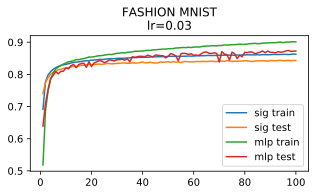

In [51]:
with open("temp/lr_0_03.pkl","rb") as f:
    store = pickle.load(f)
plt.plot(range(1,len(store["trainloss_sigmoid"])+1),store["trainloss_sigmoid"],label="sig train")
plt.plot(range(1,len(store["testloss_sigmoid"])+1),store["testloss_sigmoid"],label="sig test")
plt.plot(range(1,len(store["trainloss_mlp"])+1),store["trainloss_mlp"],label="mlp train")
plt.plot(range(1,len(store["testloss_mlp"])+1),store["testloss_mlp"],label="mlp test")
plt.legend()
plt.title("FASHION MNIST\nlr=0.03")

Text(0.5, 1.0, 'FASHION MNIST\nlr=0.3')

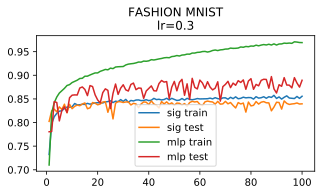

In [53]:
with open("temp/lr_0_3.pkl","rb") as f:
    store = pickle.load(f)
plt.plot(range(1,len(store["trainloss_sigmoid"])+1),store["trainloss_sigmoid"],label="sig train")
plt.plot(range(1,len(store["testloss_sigmoid"])+1),store["testloss_sigmoid"],label="sig test")
plt.plot(range(1,len(store["trainloss_mlp"])+1),store["trainloss_mlp"],label="mlp train")
plt.plot(range(1,len(store["testloss_mlp"])+1),store["testloss_mlp"],label="mlp test")
plt.legend()
plt.title("FASHION MNIST\nlr=0.3")    